# S2HC-regrid

**Date:** <br>
1 June 2022 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/7 <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='03:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.130:36099,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load Tgrid zarr

In [10]:
path = '/g/data/xv83/users/tm4888/data/ACCESS-S2/hindcast/'

In [11]:
ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid = xr.open_mfdataset(path+'accessS2.HC.ocean.masked.AUSWCPregion.nativeTgrid.nc')

In [12]:
ds_S2_HC_ocean_masked_AUSWCPregion_nativeUgrid = xr.open_mfdataset(path+'accessS2.HC.ocean.masked.AUSWCPregion.nativeUgrid.nc')

In [13]:
ds_S2_HC_ocean_masked_AUSWCPregion_nativeVgrid = xr.open_mfdataset(path+'accessS2.HC.ocean.masked.AUSWCPregion.nativeVgrid.nc')

***

# Make 0.25degree land mask
uses https://github.com/toddkarin/global-land-mask <br>
which is based on elevation data here > https://www.ngdc.noaa.gov/mgg/topo/gltiles.html

In [14]:
from global_land_mask import globe

# Lat/lon points to get
lat = np.linspace(-90,90,721)
lon = np.linspace(-180,179.75,1440)

# Make a grid
lon_grid, lat_grid = np.meshgrid(lon,lat)

# Get whether the points are on land.
z = globe.is_land(lat_grid, lon_grid)

In [15]:
land_mask = xr.DataArray(
   ...:     z,
   ...:     coords={
   ...:         "lat": lat,
   ...:         "lon": lon,
   ...:     },
   ...:     dims=["lat", "lon"],
   ...:     )

land_mask = land_mask.astype(int)
land_mask

<xarray.DataArray (lat: 721, lon: 1440)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

(100.0, 180.0)

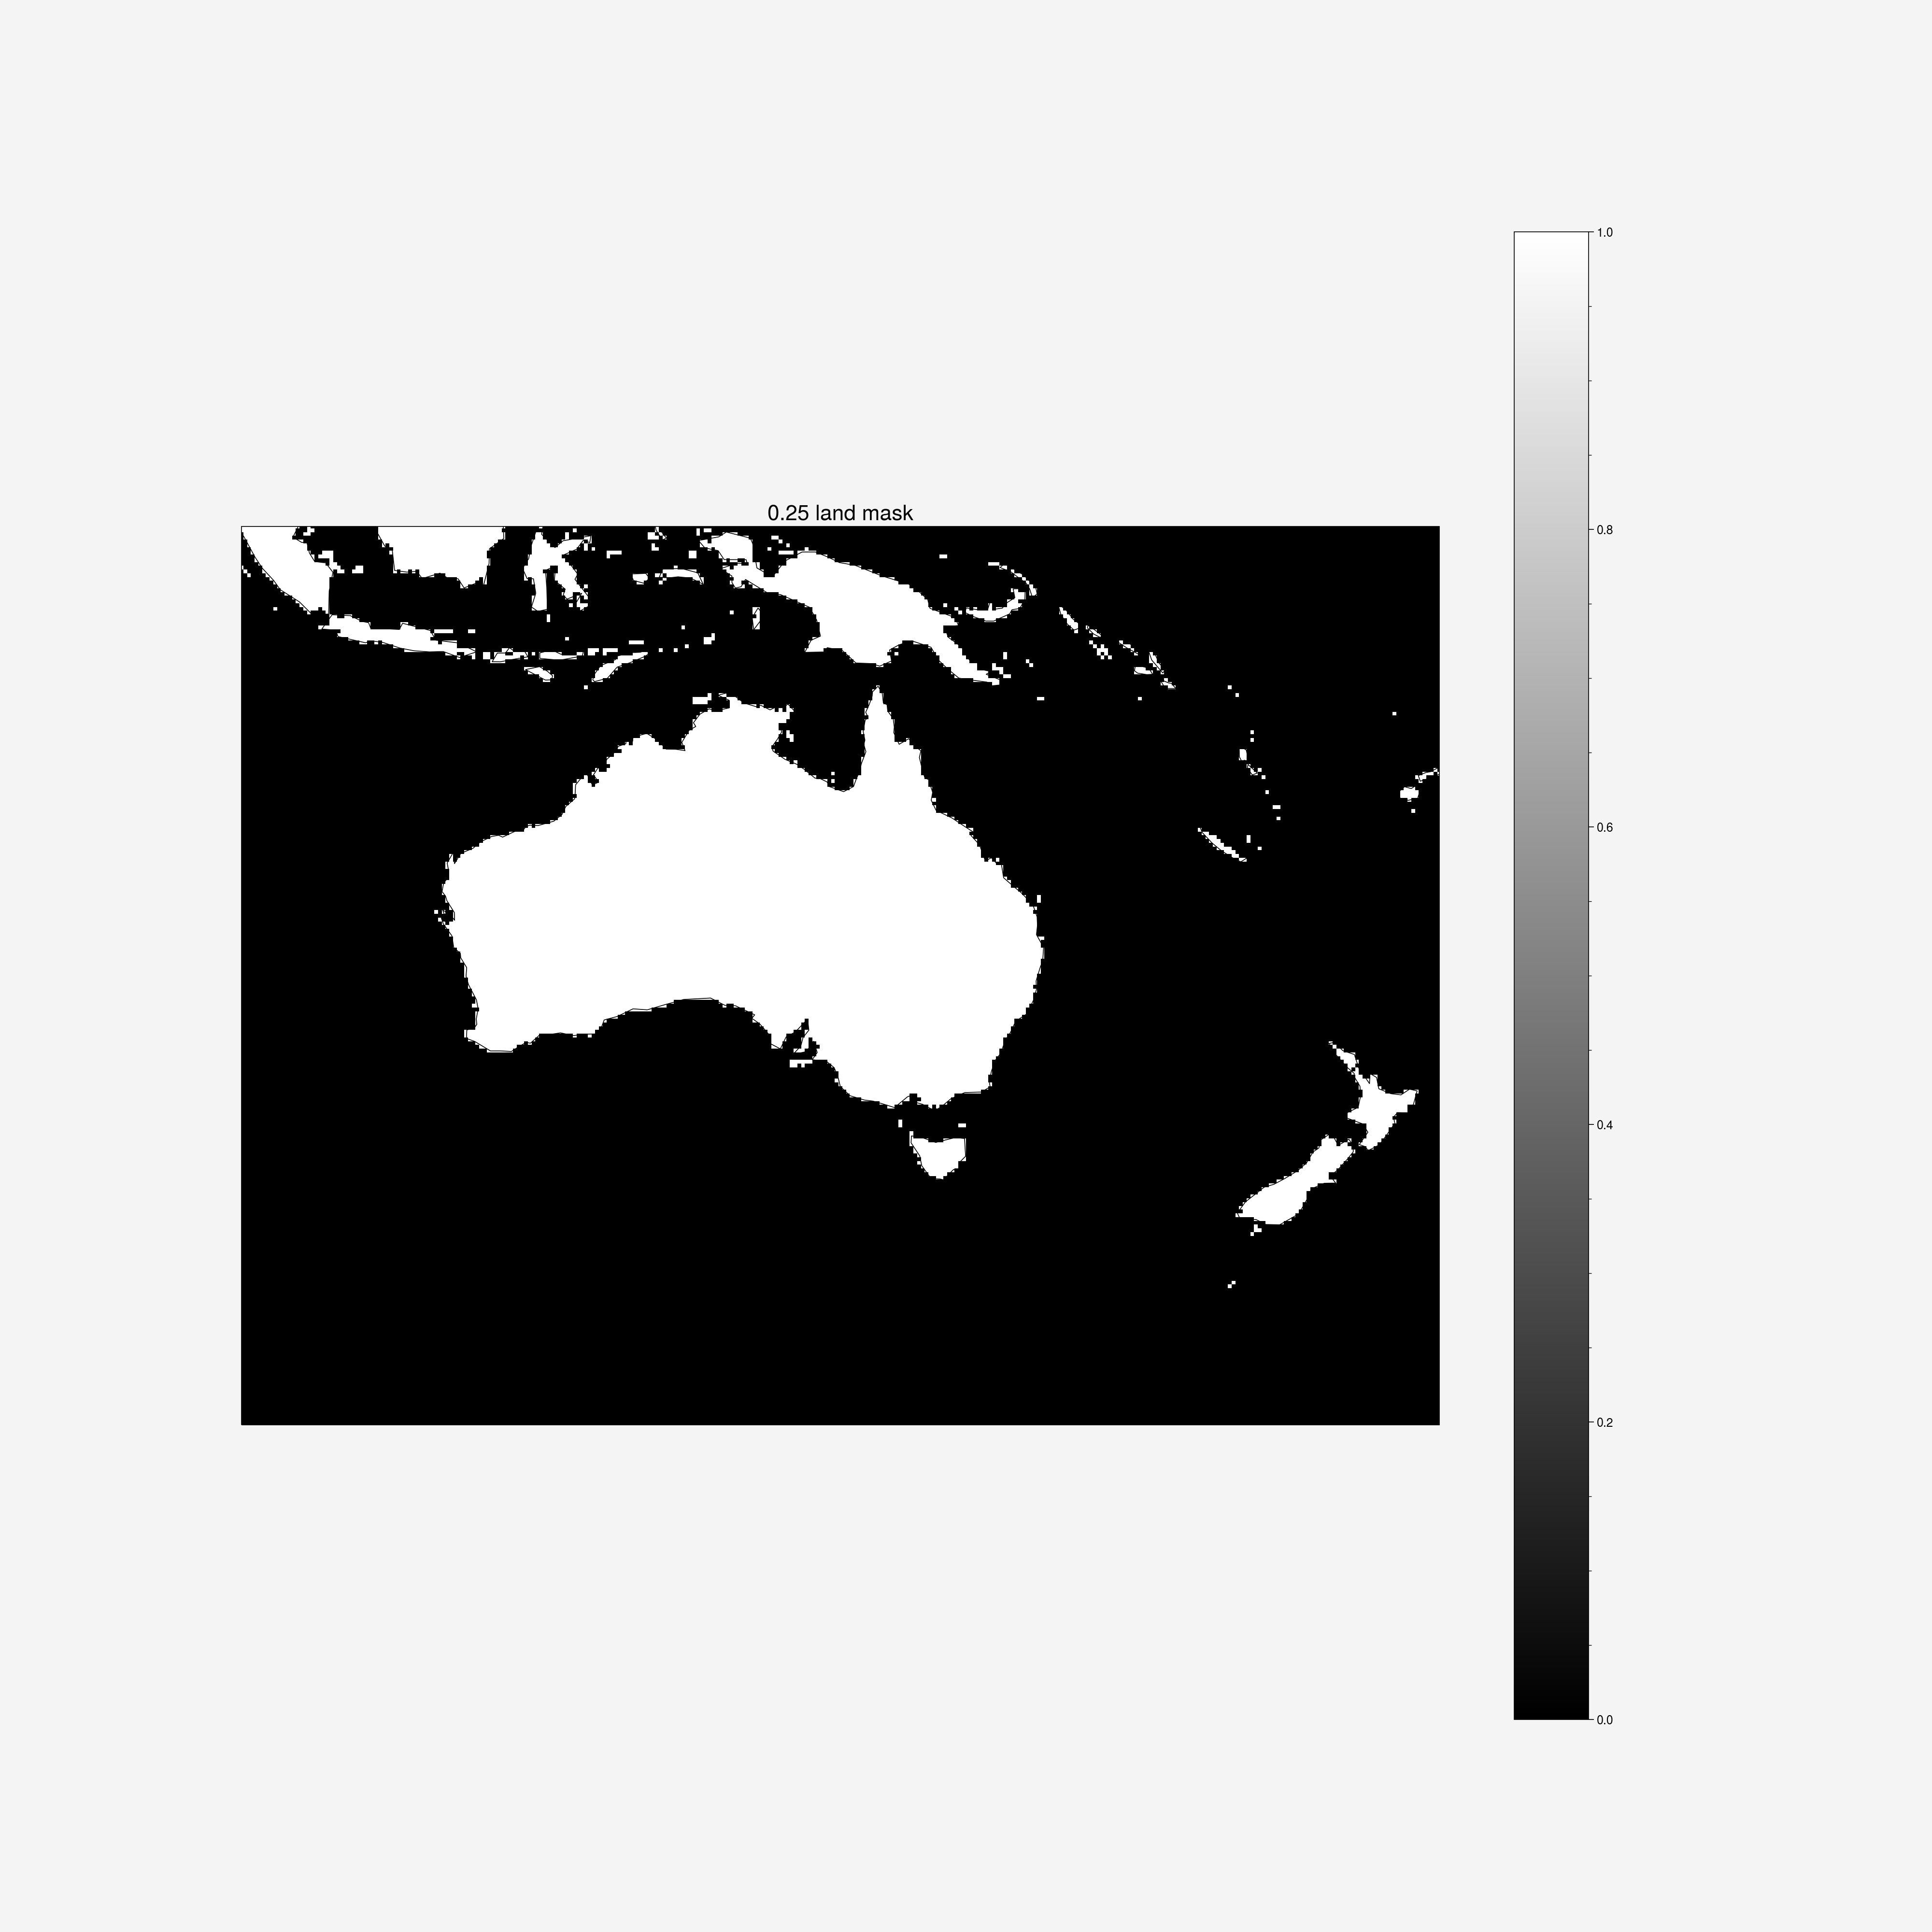

In [16]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
land_mask.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=True, cmap = 'binary_r'
)
ax.set_title('0.25 land mask', fontsize=16)
ax.coastlines()
ax.set_ylim([-60, 0])
ax.set_xlim([100, 180])

In [17]:
land_mask

<xarray.DataArray (lat: 721, lon: 1440)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

# manhandle this array to shift across the dateline

In [18]:
land_mask_shifted = (land_mask.assign_coords(lon=(land_mask.lon % 360))).sortby('lon')

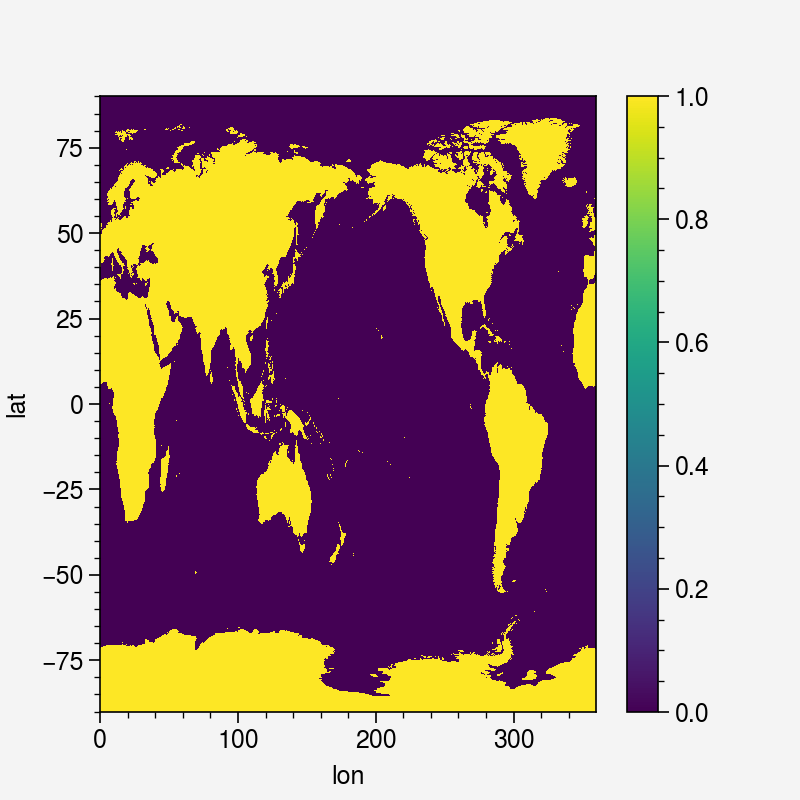

In [19]:
land_mask_shifted.plot()

In [20]:
output_mask = land_mask_shifted.where((90 <= land_mask_shifted.lon) & (land_mask_shifted.lon <= 270)
         & (-70 <= land_mask_shifted.lat) & (land_mask_shifted.lat <= 20), drop=True)

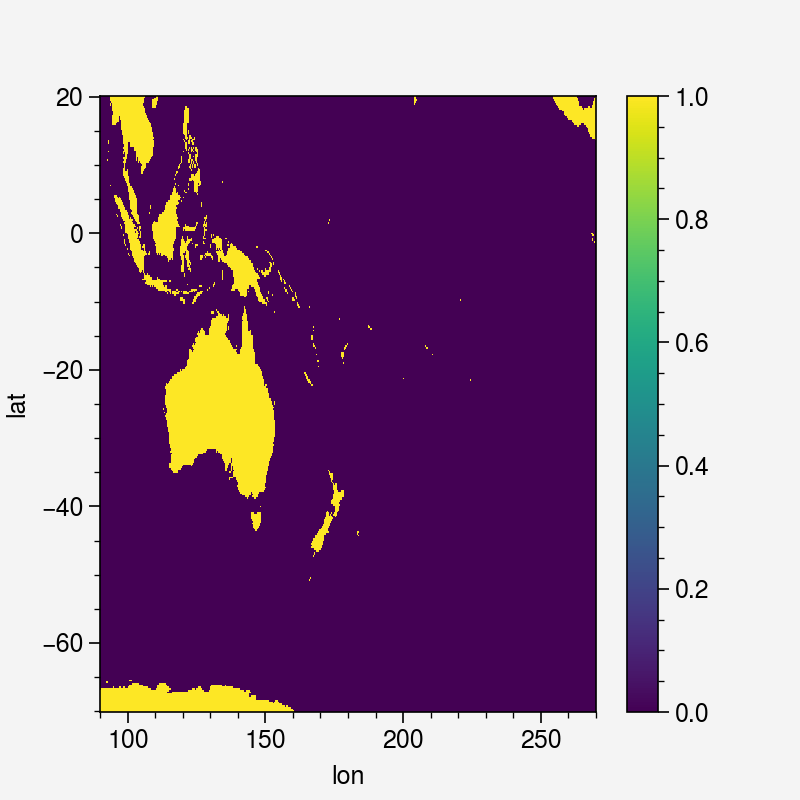

In [21]:
output_mask.plot()

In [22]:
output_mask

<xarray.DataArray (lat: 361, lon: 721)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])
Coordinates:
  * lat      (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.25 19.5 19.75 20.0
  * lon      (lon) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0

# make land (1) Nans and zeros stay finite

In [23]:
output_mask = output_mask.where(output_mask < 1, drop = True)

# <hr>
# Tgrid - Regridding Step

## curvilinear grid

In [24]:
nav_lon = ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid['lon'].compute()
nav_lat = ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid over chosen region')

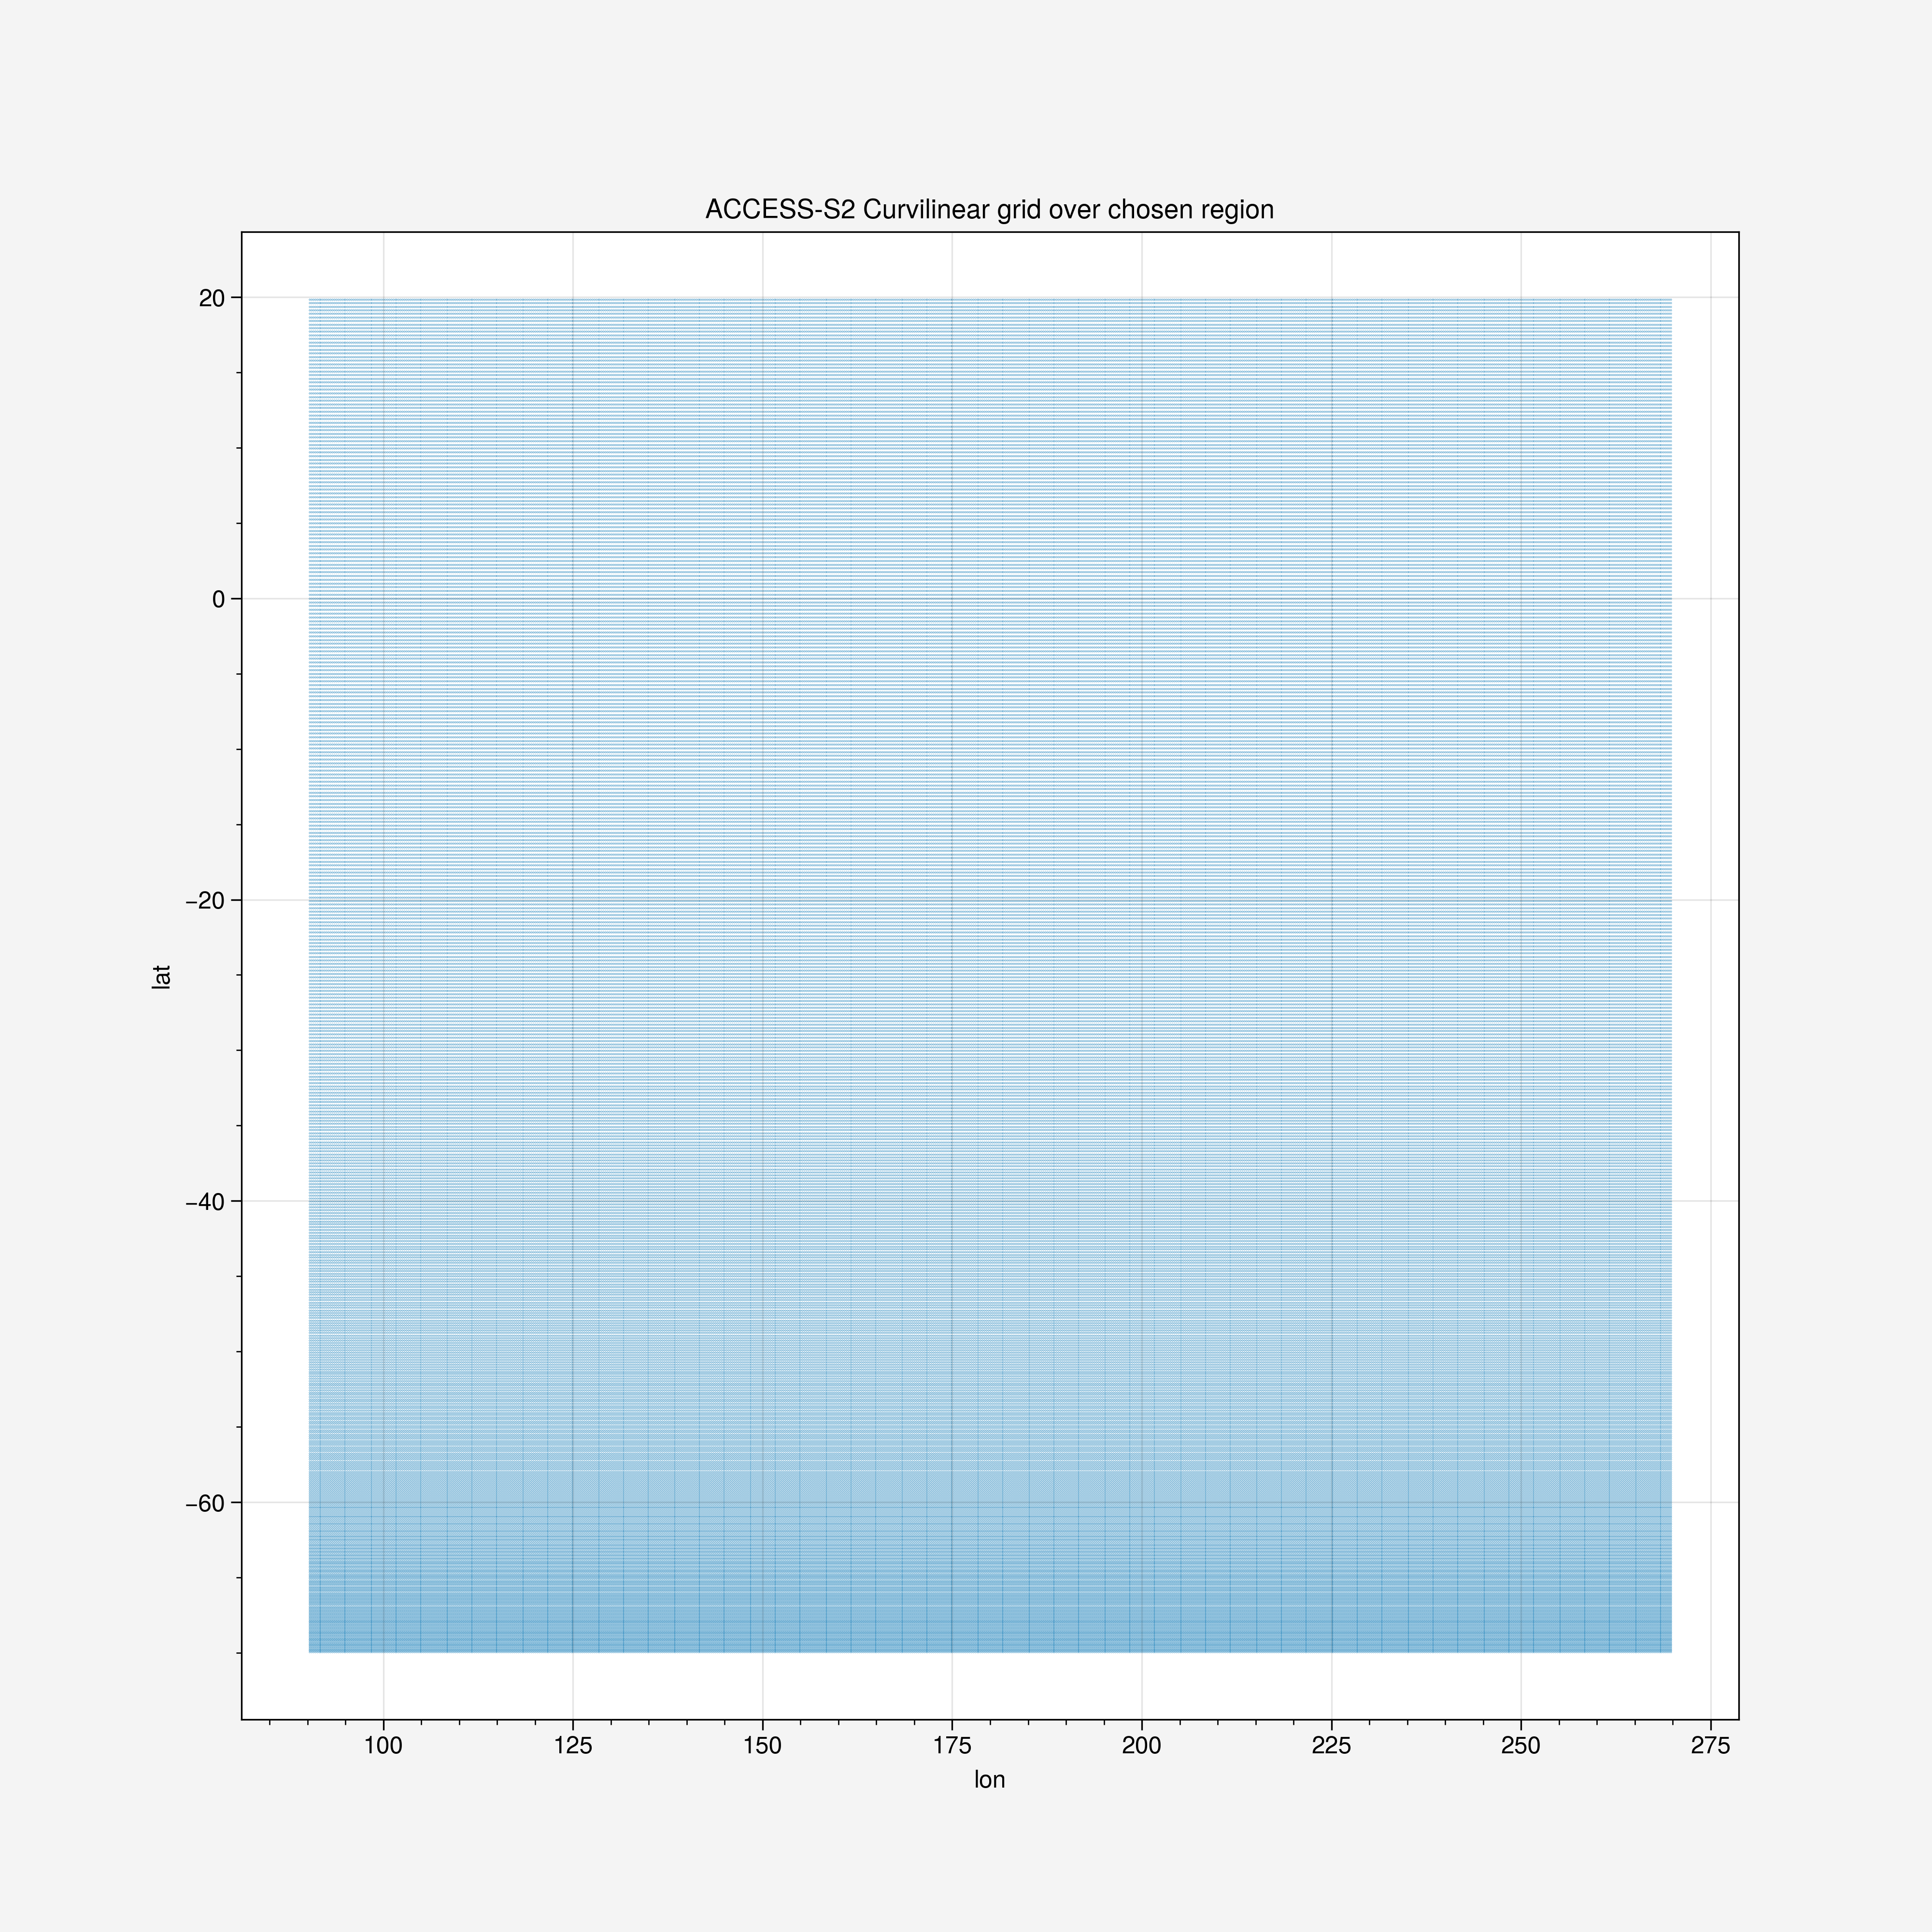

In [25]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
#plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid over chosen region')

# Define new 0.25 degree grid

In [26]:
new_025deg_grid = xe.util.grid_2d(
    89.875, 270.125, 0.25, -70.125, 20.125, 0.25 
)
new_025deg_grid

<xarray.Dataset>
Dimensions:  (y: 361, x: 721, y_b: 362, x_b: 722)
Coordinates:
    lon      (y, x) float64 90.0 90.25 90.5 90.75 ... 269.2 269.5 269.8 270.0
    lat      (y, x) float64 -70.0 -70.0 -70.0 -70.0 ... 20.0 20.0 20.0 20.0
    lon_b    (y_b, x_b) float64 89.88 90.12 90.38 90.62 ... 269.6 269.9 270.1
    lat_b    (y_b, x_b) float64 -70.12 -70.12 -70.12 ... 20.12 20.12 20.12
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

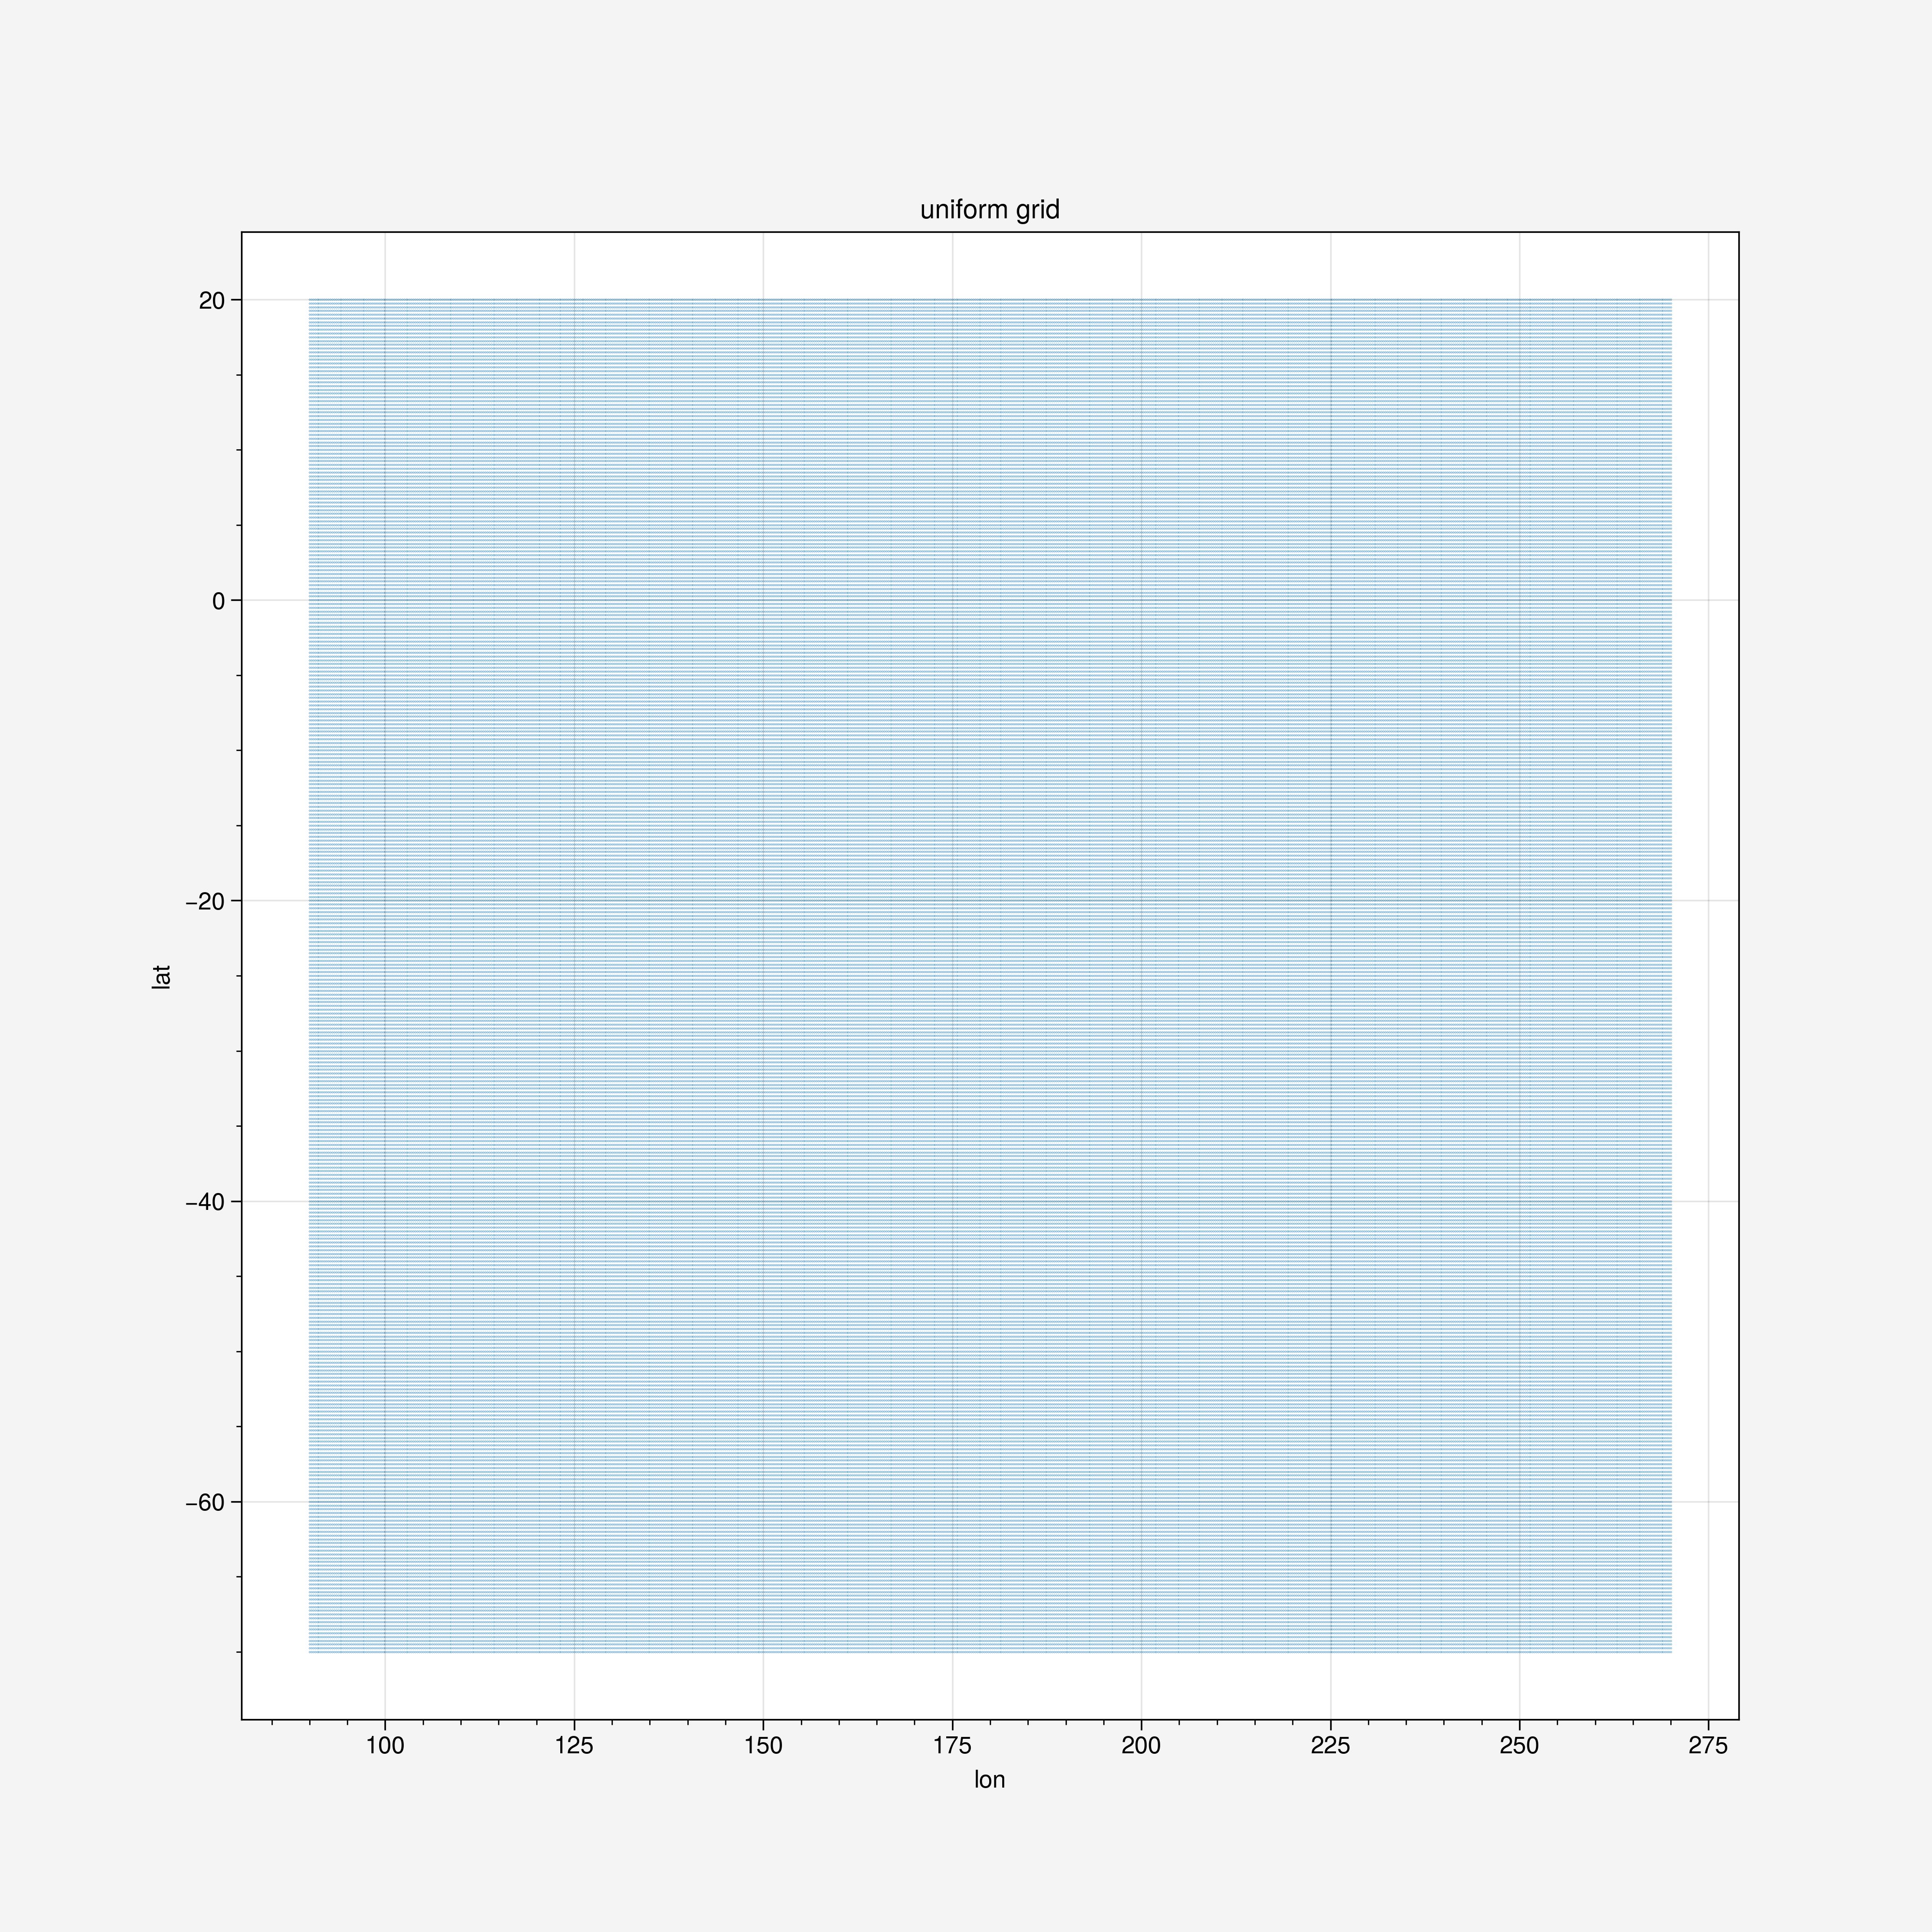

In [27]:
plt.scatter(new_025deg_grid.lon, new_025deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

# add a "mask" variable to the input to allow extrapolation

In [30]:
sst_for_mask = ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid.sst.isel(lead_time=0)
ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid['mask'] = xr.where(np.isfinite(sst_for_mask), 1, 0)

# add a "mask" variable to the output to allow extrapolation

In [31]:
new_025deg_grid['mask'] = xr.where(np.isfinite(output_mask), 1, 0)

In [32]:
%%time
regridder_S2_025deg_Tgrid = xe.Regridder(ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid, new_025deg_grid, method='bilinear', extrap_method="nearest_s2d", reuse_weights=False)

CPU times: user 21.7 s, sys: 1.47 s, total: 23.2 s
Wall time: 45.8 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the dataset object

In [33]:
%%time
regridder_S2_025deg_Tgrid._grid_in = None
regridder_S2_025deg_Tgrid._grid_out = None
ds_S2_HC_ocean_masked_AUSWCPregion_T_025grid = regridder_S2_025deg_Tgrid(ds_S2_HC_ocean_masked_AUSWCPregion_nativeTgrid)

CPU times: user 5.24 s, sys: 254 ms, total: 5.5 s
Wall time: 7.01 s


# NO LONGER REQUIRED // rename the coordinates to drop the x/y now that we are rectilinear

In [34]:
ds_S2_HC_ocean_masked_AUSWCPregion_T_025grid

<xarray.Dataset>
Dimensions:              (lead_time: 3, lat: 361, lon: 721, depth: 75, ndepth_bounds: 2, ncorners: 4)
Coordinates:
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * depth                (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    forecast_start_date  datetime64[ns] ...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
Dimensions without coordinates: ndepth_bounds, ncorners
Data variables:
    sst                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    mld1                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    areat                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    deptht_bounds        (depth, ndepth_bounds, lat, lon) float32 dask.array<chunksize=(75, 2, 361, 721), meta=np.ndarray>
    latt_bounds          (ncorners, lat, lon) float32 dask.array<chunksize=(4, 361, 721), meta=np.ndarray>
    lont_bounds          (ncorners, lat, lon) float32 dask.array<chunksize=(4, 361, 721), meta=np.ndarray>
    temp                 (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
    salt                 (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
    mask                 (lat, lon) int64 dask.array<chunksize=(361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# U grid

### add mask

In [35]:
u_for_mask = ds_S2_HC_ocean_masked_AUSWCPregion_nativeUgrid.u.isel(lead_time=0).isel(depth=0)
ds_S2_HC_ocean_masked_AUSWCPregion_nativeUgrid['mask'] = xr.where(np.isfinite(u_for_mask), 1, 0)

In [36]:
%%time
regridder_S2_025deg_Ugrid = xe.Regridder(ds_S2_HC_ocean_masked_AUSWCPregion_nativeUgrid, new_025deg_grid, method='bilinear', extrap_method="nearest_s2d", reuse_weights=False)
regridder_S2_025deg_Ugrid._grid_in = None
regridder_S2_025deg_Ugrid._grid_out = None
ds_S2_HC_ocean_masked_AUSWCPregion_U_025grid = regridder_S2_025deg_Ugrid(ds_S2_HC_ocean_masked_AUSWCPregion_nativeUgrid)
#ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.assign_coords({
#    'x': ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.lat.isel(x=0)
#    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

CPU times: user 22.3 s, sys: 626 ms, total: 22.9 s
Wall time: 34.4 s


# V grid

### mask

In [37]:
v_for_mask = ds_S2_HC_ocean_masked_AUSWCPregion_nativeVgrid.v.isel(lead_time=0).isel(depth=0)
ds_S2_HC_ocean_masked_AUSWCPregion_nativeVgrid['mask'] = xr.where(np.isfinite(v_for_mask), 1, 0)

In [38]:
%%time
regridder_S2_025deg_Vgrid = xe.Regridder(ds_S2_HC_ocean_masked_AUSWCPregion_nativeVgrid, new_025deg_grid, method='bilinear', extrap_method="nearest_s2d",reuse_weights=False)
regridder_S2_025deg_Vgrid._grid_in = None
regridder_S2_025deg_Vgrid._grid_out = None
ds_S2_HC_ocean_masked_AUSWCPregion_V_025grid = regridder_S2_025deg_Vgrid(ds_S2_HC_ocean_masked_AUSWCPregion_nativeVgrid)
#ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.assign_coords({
#    'x': ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.lat.isel(x=0)
#    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

CPU times: user 21 s, sys: 497 ms, total: 21.5 s
Wall time: 32.8 s


# Merge into one object on the new grid

#### rename masks

In [39]:
ds_S2_HC_ocean_masked_AUSWCPregion_T_025grid = ds_S2_HC_ocean_masked_AUSWCPregion_T_025grid.rename_vars({'mask':'maskT'})
ds_S2_HC_ocean_masked_AUSWCPregion_U_025grid = ds_S2_HC_ocean_masked_AUSWCPregion_U_025grid.rename_vars({'mask':'maskU'})
ds_S2_HC_ocean_masked_AUSWCPregion_V_025grid = ds_S2_HC_ocean_masked_AUSWCPregion_V_025grid.rename_vars({'mask':'maskV'})

In [40]:
ds_S2_HC_ocean_masked_AUSWCPregion_025grid = xr.merge([ds_S2_HC_ocean_masked_AUSWCPregion_T_025grid,ds_S2_HC_ocean_masked_AUSWCPregion_U_025grid,ds_S2_HC_ocean_masked_AUSWCPregion_V_025grid])

In [41]:
ds_S2_HC_ocean_masked_AUSWCPregion_025grid

<xarray.Dataset>
Dimensions:              (lead_time: 3, lat: 361, lon: 721, depth: 75, ndepth_bounds: 2, ncorners: 4)
Coordinates:
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * depth                (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    forecast_start_date  datetime64[ns] 2018-02-01
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
Dimensions without coordinates: ndepth_bounds, ncorners
Data variables: (12/26)
    sst                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    mld1                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    areat                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    ...                   ...
    depthv_bounds        (depth, ndepth_bounds, lat, lon) float32 dask.array<chunksize=(75, 2, 361, 721), meta=np.ndarray>
    latv_bounds          (ncorners, lat, lon) float32 dask.array<chunksize=(4, 361, 721), meta=np.ndarray>
    lonv_bounds          (ncorners, lat, lon) float32 dask.array<chunksize=(4, 361, 721), meta=np.ndarray>
    ocndepv              (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    v                    (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
    maskV                (lat, lon) int64 dask.array<chunksize=(361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Write out object to `zarr` collection

In [42]:
%%time
ds_S2_HC_ocean_masked_AUSWCPregion_025grid.to_zarr(store = path+'accessS2.HC.ocean.masked.AUSWCPregion.TUV_025deg.zarr',consolidated=True)

CPU times: user 4.22 s, sys: 521 ms, total: 4.75 s
Wall time: 34 s


# $\Uparrow$
# Main code
# -----------------

# Some checks, comparisons, and attempts at conservative regridding
# $\Downarrow$

# load back in 025 zarr collection

In [43]:
ds = xr.open_zarr(path+'accessS2.HC.ocean.masked.AUSWCPregion.TUV_025deg.zarr',consolidated=True)

In [44]:
ds

<xarray.Dataset>
Dimensions:              (lat: 361, lon: 721, depth: 75, ndepth_bounds: 2, lead_time: 3, ncorners: 4)
Coordinates:
  * depth                (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    forecast_start_date  datetime64[ns] ...
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
Dimensions without coordinates: ndepth_bounds, ncorners
Data variables: (12/26)
    areat                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areau                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areav                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    deptht_bounds        (depth, ndepth_bounds, lat, lon) float32 dask.array<chunksize=(75, 2, 361, 721), meta=np.ndarray>
    depthu_bounds        (depth, ndepth_bounds, lat, lon) float32 dask.array<chunksize=(75, 2, 361, 721), meta=np.ndarray>
    depthv_bounds        (depth, ndepth_bounds, lat, lon) float32 dask.array<chunksize=(75, 2, 361, 721), meta=np.ndarray>
    ...                   ...
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sst                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    temp                 (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
    u                    (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
    v                    (lead_time, depth, lat, lon) float32 dask.array<chunksize=(3, 75, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# plot up an timeslice for this masked regrid to 0.25

In [45]:
V = ds_S2_HC_ocean_masked_AUSWCPregion_025grid.v.sel(lead_time='2018-03-15',method='nearest').sel(depth=0,method='nearest').compute()

(120.0, 160.0)

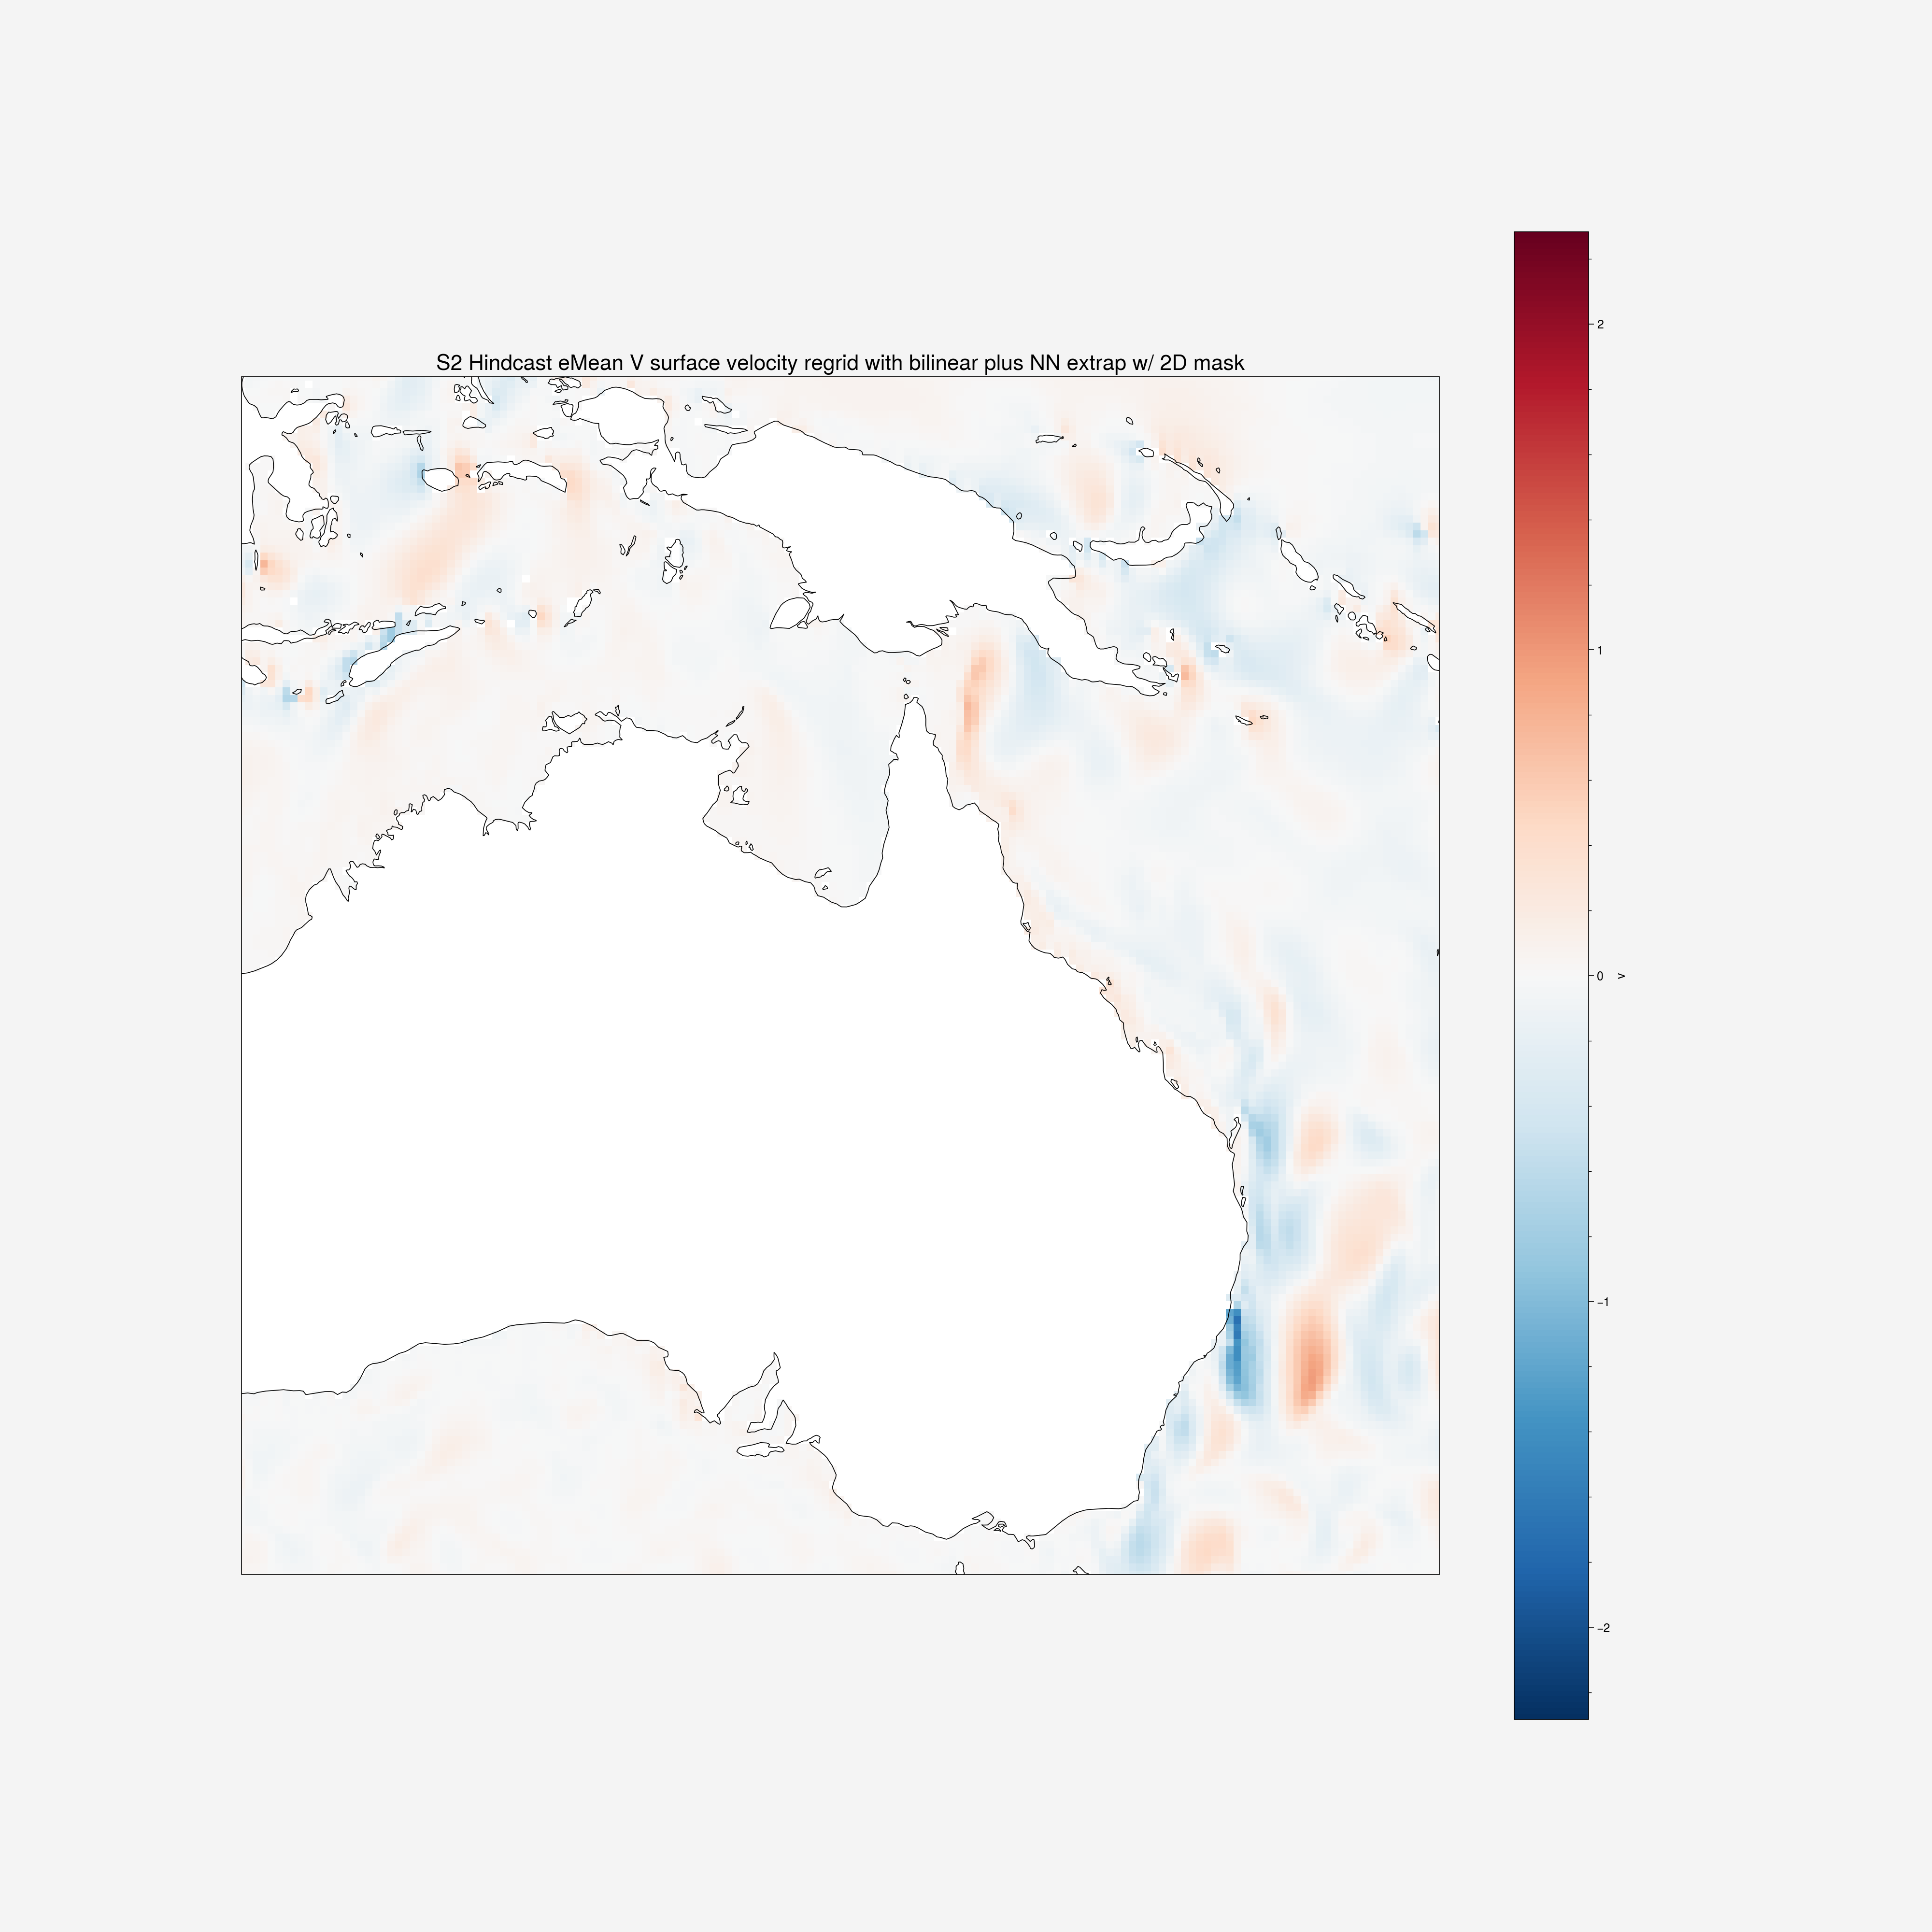

In [46]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
V.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=True
)
ax.set_title('S2 Hindcast eMean V surface velocity regrid with bilinear plus NN extrap w/ 2D mask', fontsize=16)
ax.coastlines()
ax.set_ylim([-40, 0])
ax.set_xlim([120, 160])

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [47]:
client.restart()

<Client: 'tcp://10.0.128.130:36099' processes=2 threads=4, memory=87.54 GiB>

In [82]:
client.shutdown()

In [ ]:
client.restart()